In [1]:
# Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it

# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index

# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows

# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import glob
from scipy import ndimage
from scipy import signal

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float

from bisect import bisect_left
import math


In [25]:
# Utility functions
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val

def calc_min_max_coordinates(image, crop_val=50):
    temp = thresholded(image, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def calc_min_max_coordinates_dynamic(image, cutoff=1):
    temp = exposure.equalize_adapthist(image, clip_limit=0.03)
    flat = np.sort(np.matrix.getA1(temp))
    sum_all = np.sum(flat)
    index = np.argmin(flat.cumsum() < (sum_all * cutoff))

    temp = thresholded(temp, flat[index])
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def crop_full_scan(image):
    temp = crop(image, 600, 4300, 1000, 6000)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(temp, cutoff=0.88)
    temp = crop(image, 600+ymin, 600+ymax, 1000+xmin, 1000+xmax)
    return temp, ymin, ymax, xmin, xmax

def crop_thresholded(image):
    temp = crop(image, 0, image.shape[0]-1, 0, image.shape[1]-1)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(temp, cutoff=0.82)
    temp = crop(image, ymin, ymax, xmin, xmax)
    return temp, ymin, ymax, xmin, xmax

def read_and_crop(image_name):
    if "il239838" in os.getcwd():
        image = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/P598-Fg009-R/" + image_name)
    else:
        f = urllib.request.urlopen("https://dl.dropboxusercontent.com/s/31b96942qdcn73k/" + image_name)
        image = img.imread(f, format='jpeg')

    # Smart-crop the image to get rid of all the noise and redundant area
    return crop_full_scan(image)

def read_and_crop_full_path(image_path):
    image = img.imread(image_path)

    # Smart-crop the image to get rid of all the noise and redundant area
    return crop_full_scan(image)

def read_file_list_in_dir(dir_name, file_filter="*.jpg"):
    return glob.glob("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/" +
                     dir_name + "/" + file_filter)

# TODO: fix performance!!! http://scikit-image.org/docs/dev/user_guide/tutorial_parallelization.html
def combine_3_images_to_RGB(red, green, blue):
    new_image = np.empty((blue.shape[0],blue.shape[1],3))
    for x in range(0, blue.shape[0]):
        for y in range(0, blue.shape[1]):
            new_image[x,y,0] = red[x,y]
            new_image[x,y,1] = green[x,y]
            new_image[x,y,2] = blue[x,y]
    return new_image

def slice_image_left_edge(original, width=200, rotate=0):
    rot = ndimage.rotate(original, rotate)
    # Slice the left slice of the so-called "blue" image
    left_edge_orig = crop(rot, 1, 1400, 1, width)
    left_edge_orig, ymin, ymax, xmin, xmax = crop_thresholded(left_edge_orig)

    # Copy to a new array so we don't thrash the origin
    left_edge = np.empty_like (left_edge_orig)
    np.copyto(left_edge, left_edge_orig)

    # Zero down low level "noise" values
    low_values_indices = left_edge < 30  # Where values are low
    left_edge[low_values_indices] = 0  # All low values set to 0
    return left_edge, ymin+1, ymax+1400, xmin+1, xmax+width

def get_best_angle_rotation(original, crop=True, width=200):
    min_var = 99999999999
    best_angle = -10
    for x in range(-5,5):
        if crop:            
            rot_edge = slice_image_left_edge(original, width, x)
        else:
            rot_edge = ndimage.rotate(original, x)
        left_var = np.var(rot_edge, axis=1)
        # left_var = np.apply_along_axis(lambda v: np.var(v[np.nonzero(v)]), 1, rot_edge)
        var_sum = np.sum(left_var)
        if (var_sum < min_var):
            min_var = var_sum
            best_angle = x
    print ("best_angle="+str(best_angle))
    return best_angle

def do_ridge_filter(input):
    # The ridge filter is the major eigenvalue of the Hessian matrix
    hxx, hxy, hyy = hessian_matrix(input, sigma=5)
    i1, i2 = hessian_matrix_eigvals(hxx, hxy, hyy)
    return i2

def get_signal_to_noise_ratio(input):
    f, pxx = signal.welch(input)
    #     print("VALUES: ")
    #     print(f)
    #     print(pxx)

    bisect_val = bisect_left(f, 0.01)
    noise_reduced_power = pxx[bisect_val:]
    peak_index = np.argmax(noise_reduced_power)
    peak_power = noise_reduced_power[peak_index] + noise_reduced_power[peak_index-1] + noise_reduced_power[peak_index+1]
    total_power = np.sum(noise_reduced_power)
    return peak_power / total_power
     
    
    
    

def get_image_ridge_index(image_path, rotate):
    return get_image_ridge_index_file(read_and_crop_full_path(image_path))

def get_image_ridge_index_file(image, rotate):
    if (rotate == np.iinfo(np.int32).min):
        best_rotation = get_best_angle_rotation(image, True, 280)
    else:
        best_rotation = rotate
    
    left_edge_rotated = slice_image_left_edge(image, 280, best_rotation)
    left_ridge_filtered = do_ridge_filter(left_edge_rotated)
    left_sum_filtered = np.sum(left_ridge_filtered, axis=1)
    ridge_index = get_signal_to_noise_ratio(left_sum_filtered)
    return ridge_index, best_rotation, image

def get_image_ridge_index(image_path, rotate):
    image = read_and_crop_full_path(image_path)
    if (rotate == np.iinfo(np.int32).min):
        best_rotation = get_best_angle_rotation(image, True, 280)
    else:
        best_rotation = rotate
    
    left_edge_rotated = slice_image_left_edge(image, 280, best_rotation)
    left_ridge_filtered = do_ridge_filter(left_edge_rotated)
    left_sum_filtered = np.sum(left_ridge_filtered, axis=1)
    ridge_index = get_signal_to_noise_ratio(left_sum_filtered)
    return ridge_index, best_rotation, image

In [26]:
# Image utility functions (external source)
def branchedPoints(skel):
    branch1=np.array([[2, 1, 2], [1, 1, 1], [2, 2, 2]])
    branch2=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch3=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 2]])
    branch4=np.array([[2, 1, 2], [1, 1, 2], [2, 1, 2]])
    branch5=np.array([[1, 2, 2], [2, 1, 2], [1, 2, 1]])
    branch6=np.array([[2, 2, 2], [1, 1, 1], [2, 1, 2]])
    branch7=np.array([[2, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch8=np.array([[2, 1, 2], [2, 1, 1], [2, 1, 2]])
    branch9=np.array([[1, 2, 1], [2, 1, 2], [2, 2, 1]])
    br1=mh.morph.hitmiss(skel,branch1)
    br2=mh.morph.hitmiss(skel,branch2)
    br3=mh.morph.hitmiss(skel,branch3)
    br4=mh.morph.hitmiss(skel,branch4)
    br5=mh.morph.hitmiss(skel,branch5)
    br6=mh.morph.hitmiss(skel,branch6)
    br7=mh.morph.hitmiss(skel,branch7)
    br8=mh.morph.hitmiss(skel,branch8)
    br9=mh.morph.hitmiss(skel,branch9)
    return br1+br2+br3+br4+br5+br6+br7+br8+br9

def endPoints(skel):
    endpoint1=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8
    return ep

def pruning(skeleton, size):
    '''remove iteratively end points "size" 
       times from the skeleton
    '''
    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')
    
    
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xticks([])
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf



In [12]:
# merge 3 images in a linear average and check if the ridge index is better... hint: NO!
images_paths = read_file_list_in_dir("P598-Fg009-R", "*LR7*.jpg")
merged_image = np.mean( np.array([img.imread(images_paths[0]), \
                                  img.imread(images_paths[1]), \
                                  img.imread(images_paths[2])]), axis=0 )
merged_image = np.uint8(merged_image)
cropped_merged = crop_full_scan(merged_image)

image_rotation = 4 # np.iinfo(np.int32).min

ridge_index, image_rotation, image = get_image_ridge_index_file(cropped_merged, image_rotation)
print("--------INDEX:"+str(ridge_index)) 



--------INDEX:0.474053059054


In [33]:
# TRYING !!! to merge 3 images AFTER we calculate the hessian matrix and then check it...
images_paths = read_file_list_in_dir("P598-Fg009-R", "*LR7*.jpg")

image_yy = []
image_rotation = 4
first = True
xmin = -1
ymin = -1
xmax = -1
ymax = -1
for image_path in images_paths:
    single_image = img.imread(image_path)
    if first:
        cropped, ymin, ymax, xmin, xmax = crop_full_scan(single_image)
        first = False
    else:
        cropped = crop(single_image, 600, 4300, 1000, 6000)
        cropped = crop(single_image, 600+ymin, 600+ymax, 1000+xmin, 1000+xmax)
    print(cropped.shape)
#     left_edge_rotated = slice_image_left_edge(cropped, 280, image_rotation)
    left_edge_rotated = cropped
    hxx, hxy, hyy = hessian_matrix(left_edge_rotated, sigma=5)
    image_yy.append((image_path, hyy))
  
merged_yy = np.mean( np.array([image_yy[0][1], \
                                image_yy[1][1], \
                                image_yy[2][1]]), axis=0 )

merged_yy = np.uint8(merged_yy)

merged_yy.shape

# ridge_index, image_rotation, image = get_image_ridge_index_file(merged_yy, image_rotation)
# print("--------INDEX:"+str(ridge_index)) 



(1286, 2933)
(1286, 2933)
(1286, 2933)


(1286, 2933)

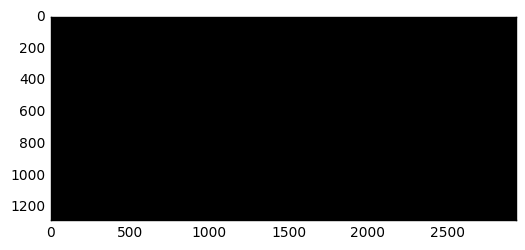

In [36]:
plt.imshow(merged_yy, cmap='gray')
# ridge_index, image_rotation, image = get_image_ridge_index_file(merged_yy, image_rotation)
# print("--------INDEX:"+str(ridge_index)) 